# Experiments for Vehicle Detection and Tracking

This notebook is basically a notebook with several experiments made with just a few images/small dataset for the project. The codes in the cells is later used for the final python programm, but variations of course will appear.

In [45]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog

# Helper functions:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    for boxes in bboxes:
        cv2.rectangle(draw_img, boxes[0], boxes[1], color, thick)
    return draw_img

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

def bin_spatial(img, size=(32, 32)):
    imgcopy = img.copy()
    imgcopy = cv2.resize(imgcopy, size)
    features = imgcopy.ravel()
    return features

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    image = mpimg.imread(car_list[0])
    data_dict["image_shape"] = image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = image.dtype
    # Return data_dict
    return data_dict

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

def scale_features(features):
    from sklearn.preprocessing import StandardScaler
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(features)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(features)
    return scaled_X, X_scaler

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),
                        orient=9, pix_per_cell=8, cell_per_block=2, 
                        hog_channel="ALL", vis=False, feature_vec=True, 
                        use_spacial=True, use_hist=True, use_hog=True):
    # Create a list to append feature vectors to
    features = []
    for image in imgs:
        img = mpimg.imread(image)
        imgcopy = img.copy()
        f = extract_features_img(imgcopy, cspace=cspace, spatial_size=spatial_size, 
                                 hist_bins=hist_bins, hist_range=hist_range, orient=orient,
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, vis=vis, feature_vec=feature_vec, 
                                 use_spacial=use_spacial, use_hist=use_hist, use_hog=use_hog)
        #print("f shape:", f.shape)
        features.append(f) 
    return features

def extract_features_img(img, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),
                        orient=9, pix_per_cell=8, cell_per_block=2, 
                        hog_channel="ALL", vis=False, feature_vec=True, 
                        use_spacial=True, use_hist=True, use_hog=True):
    imgcopy = img.copy()
    imgcopy_fixed_res = cv2.resize(imgcopy, (32, 32))
    conversions = ['cv2.COLOR_RGB2HSV', 'cv2.COLOR_RGB2HLS', 'cv2.COLOR_RGB2LUV', 'cv2.COLOR_RGB2BGR']
    conv_pos = ["HSV", "HLS", "LUV", "BRG"]
    if cspace != 'RGB':
        conv = eval(conversions[conv_pos.index(cspace)])
        imgcopy = cv2.cvtColor(imgcopy, conv)
    f1 = bin_spatial(imgcopy, size=spatial_size) if use_spacial else []
    _,_,_,_,f2 = color_hist(imgcopy_fixed_res, nbins=hist_bins, bins_range=hist_range) if use_hist else []
    f3 = []
    if hog_channel == 'ALL':
        for channel in range(imgcopy_fixed_res.shape[2]):
            f3.append(get_hog_features(imgcopy_fixed_res[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        f3 = np.ravel(f3)        
    else:
        f3 = get_hog_features(imgcopy_fixed_res[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    #print("debug:")
    #print("f1 shape: ", f1.shape)
    #print("f2 shape: ", f2.shape)
    #print("f3 shape: ", f3.shape)
    f = np.concatenate((f1, f2, f3))
    return f

def fit_clf(features, targets):
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svr = svm.SVC()
    clf = grid_search.GridSearchCV(svr, parameters)
    clf.fit(iris.data, iris.target)

## IO Code
Read in images from the data set. The data has a vehicles and non-vehicles folder for the different classes. Within the folders there are subfolders, then .png files within.

In [2]:
def read_data_set(basepath):
    import os
    vehicle_path = os.path.join(basepath, 'vehicles')
    vehicle_data = read_img_files_from_subfolders(vehicle_path)
    non_vehicle_path = os.path.join(basepath, 'non-vehicles')
    non_vehicle_data = read_img_files_from_subfolders(non_vehicle_path)
    return vehicle_data, non_vehicle_data

def read_img_files_from_subfolders(path):
    import glob
    pattern = path + '/**/*.png'
    files = glob.glob(pattern, recursive=True)
    return files

vehicle_files, non_vehicle_files = read_data_set("../data")
data_look(vehicle_files, non_vehicle_files)

{'data_type': dtype('float32'),
 'image_shape': (64, 64, 3),
 'n_cars': 8792,
 'n_notcars': 8968}

## Feature Extraction
now we have the paths to the dataset we must extract the features for each instance to get a vecture vector, and stack that in a veature matrix and a target vector

In [46]:
vehicle_features = extract_features(vehicle_files, cspace="HSV", use_spacial=False, spatial_size=(16,16))
non_vehicle_features = extract_features(non_vehicle_files, cspace="HSV", use_spacial=False, spatial_size=(16,16))

In [47]:
print("vehicle_features shape:", vehicle_features[0].shape)

vehicle_features shape: (1068,)


In [49]:
X = np.vstack((vehicle_features + non_vehicle_features)).astype(np.float64)                        
scaled_X, X_scaler = scale_features(X)

y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

## Fit Model and test
now we have the features and the target vector, we can finally train our model. We split the sample into a 20% train, test split

In [50]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9535


In [19]:
# save the model to disk:
import pickle
with open('svc.p', 'wb') as f:
    pickle.dump(svc, f)

# Sliding Window & Pipeline Experiments
This Notebook is basically a set of experiments for the real detection pipeline. Concretely it uses some test images to experiment and visualize with the sliding window computation strategy, and experiments for finding a suteable threshold for the headmap.

## Helper functions
A set of functions needed for the rest. Ususally I move that into a own python file later and include it ihere, or move it to the bottom...

In [20]:
import numpy as np
import cv2

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    def cond_set(val, default):
        return val if val is not None else default
    
    x_start_stop[0] = cond_set(x_start_stop[0], 0)
    x_start_stop[1] = cond_set(x_start_stop[1], img.shape[1])
    
    y_start_stop[0] = cond_set(y_start_stop[0], 0)
    y_start_stop[1] = cond_set(y_start_stop[1], img.shape[0])
    
    span = (x_start_stop[1]-x_start_stop[0], y_start_stop[1] - y_start_stop[0])
    step = (int(xy_window[0]*xy_overlap[0]), int(xy_window[1]*xy_overlap[1]))
    shape = (np.int((span[0]-step[0])/step[0]), np.int((span[1]-step[1])/step[1]))
    num = shape[0]*shape[1]
    #print("debug: ", x_start_stop, y_start_stop, span, step, shape, num)
    window_list = []
    for ys in range(shape[1]):
        for xs in range(shape[0]):
            startx = xs*step[0] + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*step[1] + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

## Find slidning windows
We define sliding windows to search for cars. To not blow the computations we try to minimise the effort, but still have a good detection rate. Therefor we limit the search area to approx. the lower half of the image. Also do be less resolution dependent different sized sliding windows are used who then are all down or upsampled to the same size.

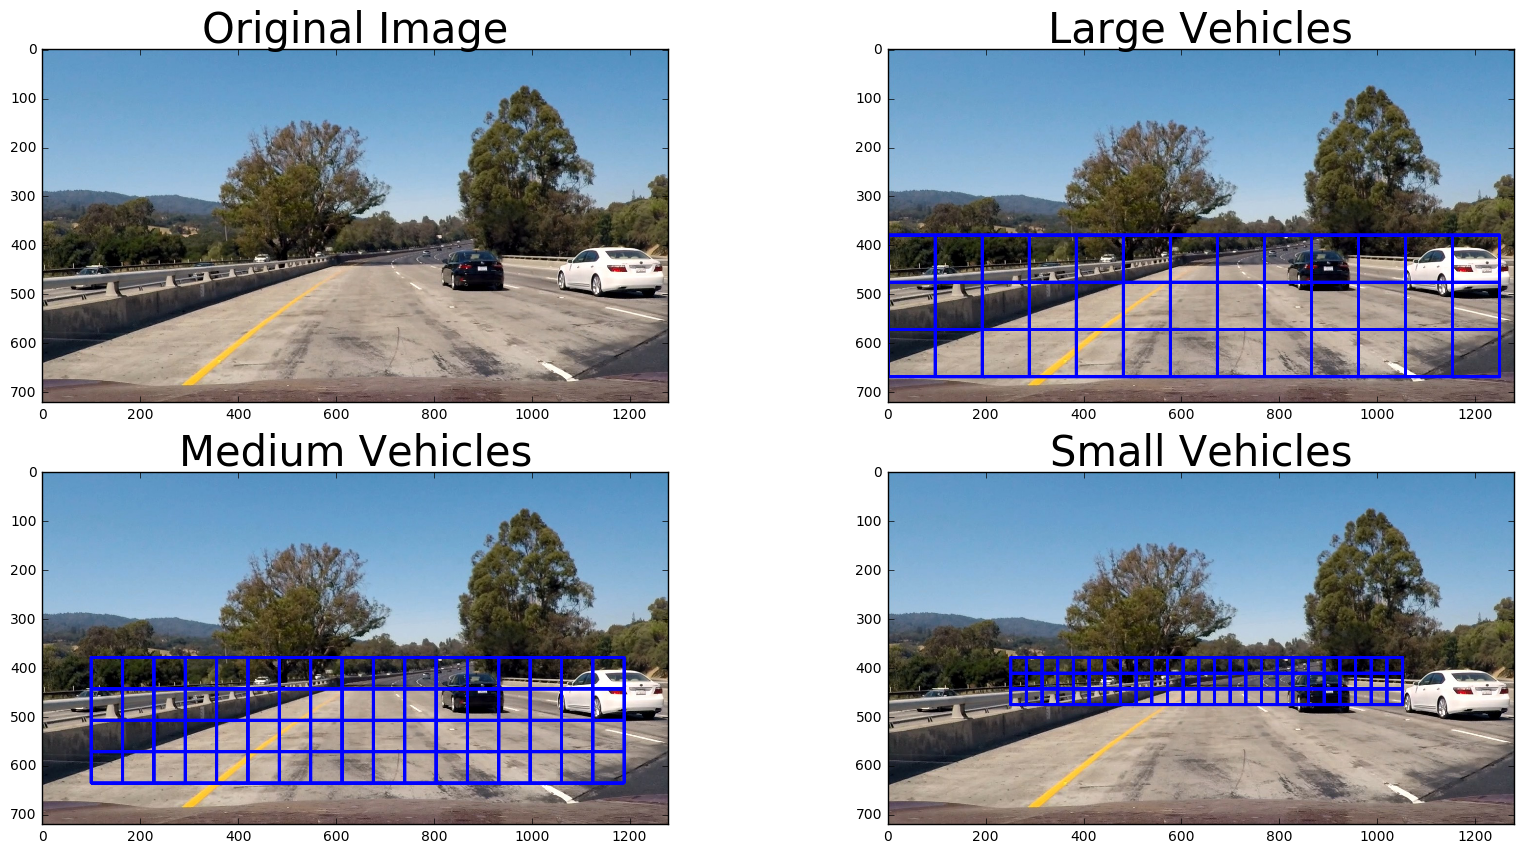

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

image = mpimg.imread('../test_images/test1.jpg')
f, axarr = plt.subplots(2, 2, figsize=(20,10))

axarr[0, 0].imshow(image)
axarr[0, 0].set_title('Original Image', fontsize=30)

layer1 = slide_window(image, y_start_stop=[380, None], xy_window=(192,192))
l1img = draw_boxes(image, layer1)

axarr[0, 1].imshow(l1img)
axarr[0, 1].set_title('Large Vehicles', fontsize=30)

layer2 = slide_window(image, y_start_stop=[380, 650], x_start_stop=[100, 1200], xy_window=(128,128))
l2img = draw_boxes(image, layer2)

axarr[1, 0].imshow(l2img)
axarr[1, 0].set_title('Medium Vehicles', fontsize=30)

layer3 = slide_window(image, y_start_stop=[380, 500], x_start_stop=[250, 1050], xy_window=(64,64))
l3img = draw_boxes(image, layer3)

axarr[1, 1].imshow(l3img)
axarr[1, 1].set_title('Small Vehicles', fontsize=30)

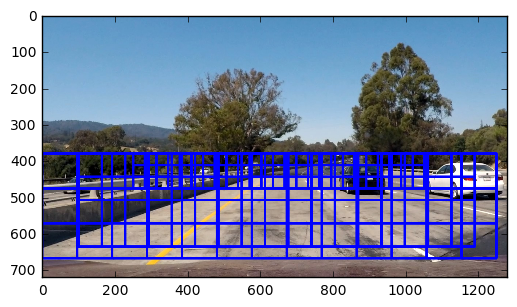

In [22]:
layer1 = slide_window(image, y_start_stop=[380, None], xy_window=(192,192))
layer2 = slide_window(image, y_start_stop=[380, 650], x_start_stop=[100, 1200], xy_window=(128,128))
layer3 = slide_window(image, y_start_stop=[380, 500], x_start_stop=[250, 1050], xy_window=(64,64))
all_layers = layer1 + layer2 + layer3

all_img = draw_boxes(image, all_layers)
plt.imshow(all_img)

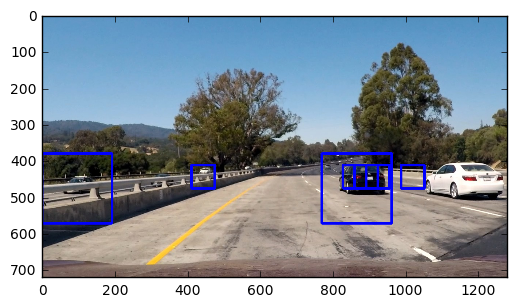

In [54]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
        #4) Extract features for that window using single_img_features()
        features = extract_features_img(test_img, cspace="HSV", use_spacial=False, spatial_size=(16,16))
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

found = search_windows(image, all_layers, svc, X_scaler)
test_img = draw_boxes(image, found)
plt.imshow(test_img)